# Financial transcation analysis and Fraud detection

### Data Loading

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
df = pd.read_csv('financial_transactions.csv')

df.head()

,TransactionID,CustomerID,TransactionDate,ProductID,Amount,PaymentType,Country,MerchantID,IsFraudulent,Category,CustomerAge,CustomerEmailDomain,TransactionTime,ProductDescription,Quantity,IPAddress,DeviceID,TransactionStatus
0,1,103,2023-01-01 00:00:00,31,50000.0,Debit Card,France,1169,0,Books,25.0,hotmail.com,00:00:00,Poor,8.0,NaN,824,Cancelled
1,2,436,2023-01-01 01:00:00,24,75000.0,Debit Card,Australia,1550,0,Books,25.0,gmail.com,00:45:00,Average,3.0,172.16.0.1,924,Cancelled
2,3,349,2023-01-01 02:00:00,99,100000.0,Wire Transfer,USA,1454,0,Electronics,65.0,gmail.com,01:30:00,Average,5.0,127.0.0.1,850,Pending
3,4,271,2023-01-01 03:00:00,60,125000.0,PayPal,Australia,1650,0,Sports,NaN,gmail.com,02:15:00,Average,7.0,10.0.0.1,78,Completed
4,5,107,2023-01-01 04:00:00,45,150000.0,Credit Card,France,1291,0,Clothing,55.0,yahoo.com,03:00:00,Average,NaN,127.0.0.1,440,Completed


In [3]:
# Display the size of the dataset
dataset_size = df.shape
dataset_size

(2000, 18)

In [4]:
# Display data types of the columns
column_data_types = df.dtypes
column_data_types

TransactionID            int64
CustomerID               int64
TransactionDate         object
ProductID                int64
Amount                 float64
PaymentType             object
Country                 object
MerchantID               int64
IsFraudulent             int64
Category                object
CustomerAge            float64
CustomerEmailDomain     object
TransactionTime         object
ProductDescription      object
Quantity               float64
IPAddress               object
DeviceID                 int64
TransactionStatus       object
dtype: object

### Data Cleaning and Preparation 

In [6]:
# Check for missing values in each column
missing_values = df.isnull().sum()
missing_values

TransactionID            0
CustomerID               0
TransactionDate          0
ProductID                0
Amount                  99
PaymentType              0
Country                  0
MerchantID               0
IsFraudulent             0
Category                 0
CustomerAge            294
CustomerEmailDomain      0
TransactionTime          0
ProductDescription     193
Quantity               100
IPAddress              404
DeviceID                 0
TransactionStatus        0
dtype: int64

In [7]:
# Check for duplicate rows
duplicate_rows = df.duplicated().sum()
duplicate_rows

0

In [8]:
# Convert TransactionDate and TransactionTime into a single datetime column
df['TransactionDateTime'] = pd.to_datetime(df['TransactionDate'] + ' ' + df['TransactionTime'])

# Drop the original TransactionDate and TransactionTime columns
df.drop(['TransactionDate', 'TransactionTime'], axis=1, inplace=True)

# Impute missing values for Amount and Quantity with the median (to minimize the impact of outliers)
df['Amount'].fillna(df['Amount'].median(), inplace=True)
df['Quantity'].fillna(df['Quantity'].median(), inplace=True)

# Impute missing values for CustomerAge with the median
df['CustomerAge'].fillna(df['CustomerAge'].median(), inplace=True)

# Impute missing values for ProductDescription and IPAddress with the mode (most common value)
for column in ['ProductDescription', 'IPAddress']:
    mode_value = df[column].mode()[0]
    df[column].fillna(mode_value, inplace=True)

# Recheck missing values to confirm cleaning
rechecked_missing_values = df.isnull().sum()

# Check the new distribution of the Amount column to plan outlier handling
amount_describe = df['Amount'].describe()

rechecked_missing_values, amount_describe

(TransactionID          0
 CustomerID             0
 ProductID              0
 Amount                 0
 PaymentType            0
 Country                0
 MerchantID             0
 IsFraudulent           0
 Category               0
 CustomerAge            0
 CustomerEmailDomain    0
 ProductDescription     0
 Quantity               0
 IPAddress              0
 DeviceID               0
 TransactionStatus      0
 TransactionDateTime    0
 dtype: int64,
 count      2000.000000
 mean        759.715985
 std        5281.999819
 min           5.190000
 25%         281.972500
 50%         524.340000
 75%         750.650000
 max      150000.000000
 Name: Amount, dtype: float64)

In [9]:
# Outlier detection and handling in the "Amount" column using the IQR method
Q1 = df['Amount'].quantile(0.25)
Q3 = df['Amount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identifying outliers
outliers = df[(df['Amount'] < lower_bound) | (df['Amount'] > upper_bound)]

# Handling outliers by capping them at the upper bound (for simplicity)
df.loc[df['Amount'] > upper_bound, 'Amount'] = upper_bound

# Rechecking the distribution of the Amount column after outlier handling
new_amount_describe = df['Amount'].describe()
outliers_count = outliers.shape[0]

new_amount_describe, outliers_count


(count    2000.000000
 mean      513.350151
 std       282.019421
 min         5.190000
 25%       281.972500
 50%       524.340000
 75%       750.650000
 max      1453.666250
 Name: Amount, dtype: float64,
 5)

### Exploratory Data Analysis (EDA)

#### Distribution of Transactions Over Time

The plot illustrates how transactions are distributed across the time period covered in the dataset. While this visualization doesn't show a clear trend or seasonality due to the dataset's scope and granularity, it provides a baseline understanding of transaction activity over time.

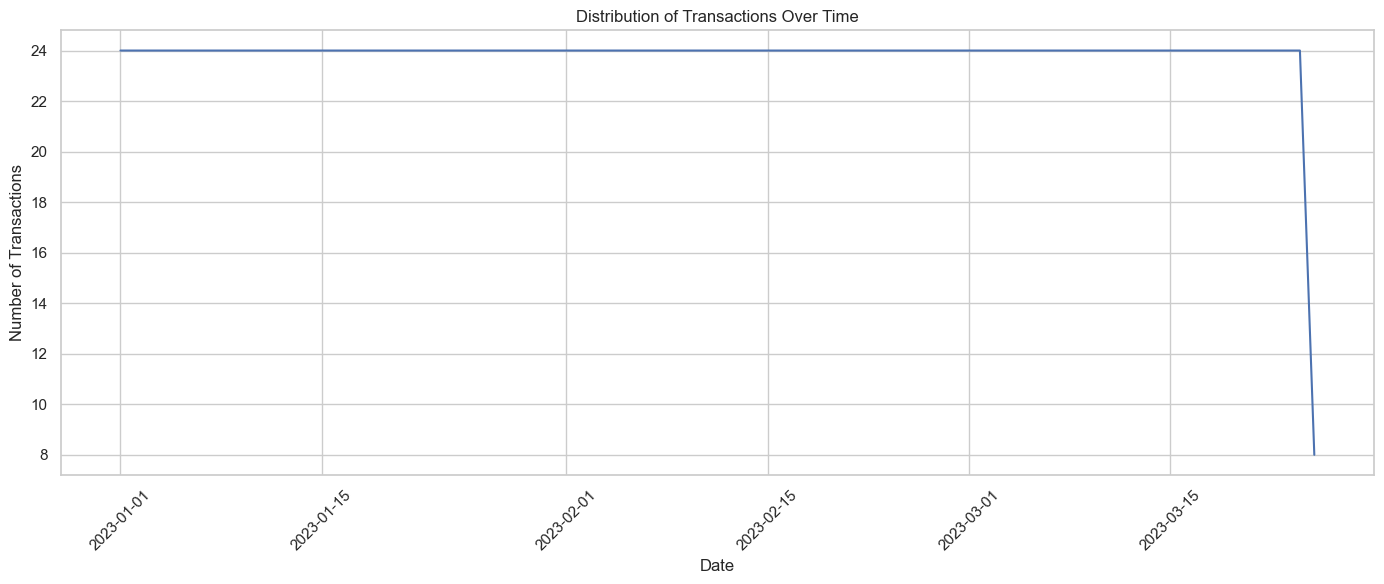

In [10]:
sns.set(style="whitegrid")
plt.figure(figsize=(14, 6))
plt.plot(df.groupby(df['TransactionDateTime'].dt.date)['TransactionID'].count())
plt.title('Distribution of Transactions Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Transaction Amount Analysis by Category

The boxplot shows the distribution of transaction amounts within each product category. Some categories exhibit a wider range of transaction amounts, indicating variability in product prices or purchasing behaviors. Notably, outliers are present across various categories, even after adjusting for extreme values in the Amount column, suggesting that high-value transactions are not uncommon in certain categories.

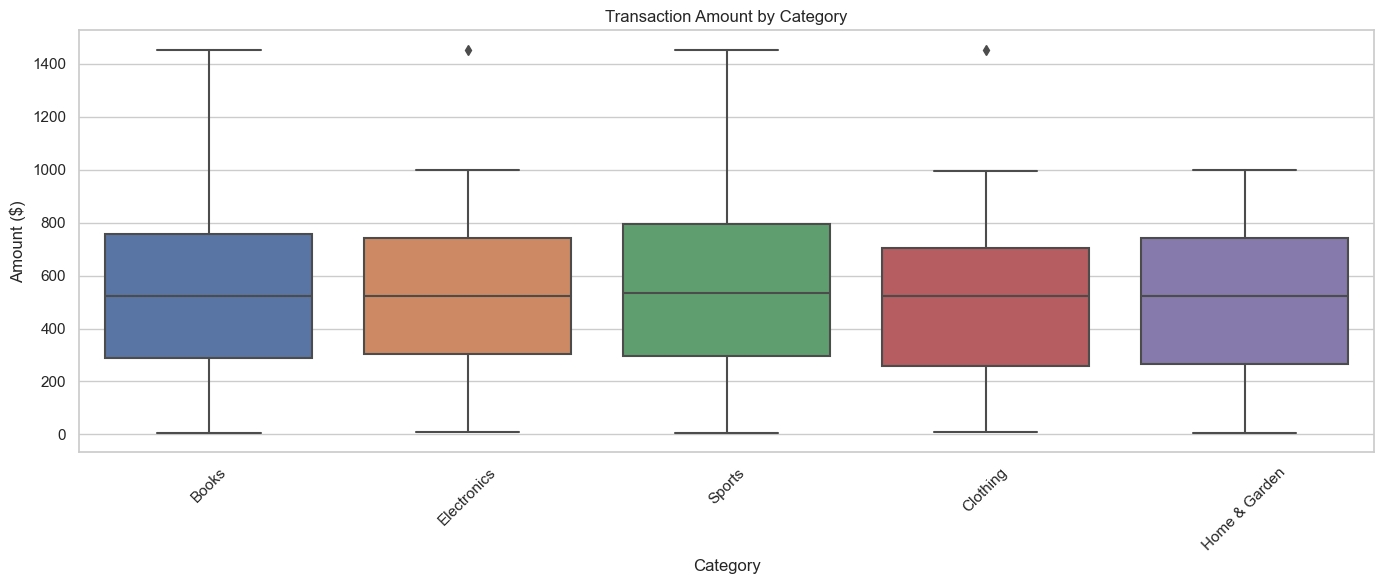

In [11]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='Category', y='Amount', data=df)
plt.title('Transaction Amount by Category')
plt.xlabel('Category')
plt.ylabel('Amount ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Fraud Analysis: Investigate the distribution of fraudulent vs. non-fraudulent transactions

#### Customer Age Distribution in Relation to Fraud

The KDE plot shows the distribution of customer age for both fraudulent and non-fraudulent transactions. There appears to be a notable age distribution difference between the two categories. Such insights can help in understanding if age is a significant factor in predicting fraudulent activity.

/var/folders/n3/wq3qj7vn3c12xjhrsq0nrmcr0000gn/T/ipykernel_6864/2224489151.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['IsFraudulent'] == 0]['CustomerAge'], label='Not Fraudulent', shade=True)
/var/folders/n3/wq3qj7vn3c12xjhrsq0nrmcr0000gn/T/ipykernel_6864/2224489151.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['IsFraudulent'] == 1]['CustomerAge'], label='Fraudulent', shade=True)


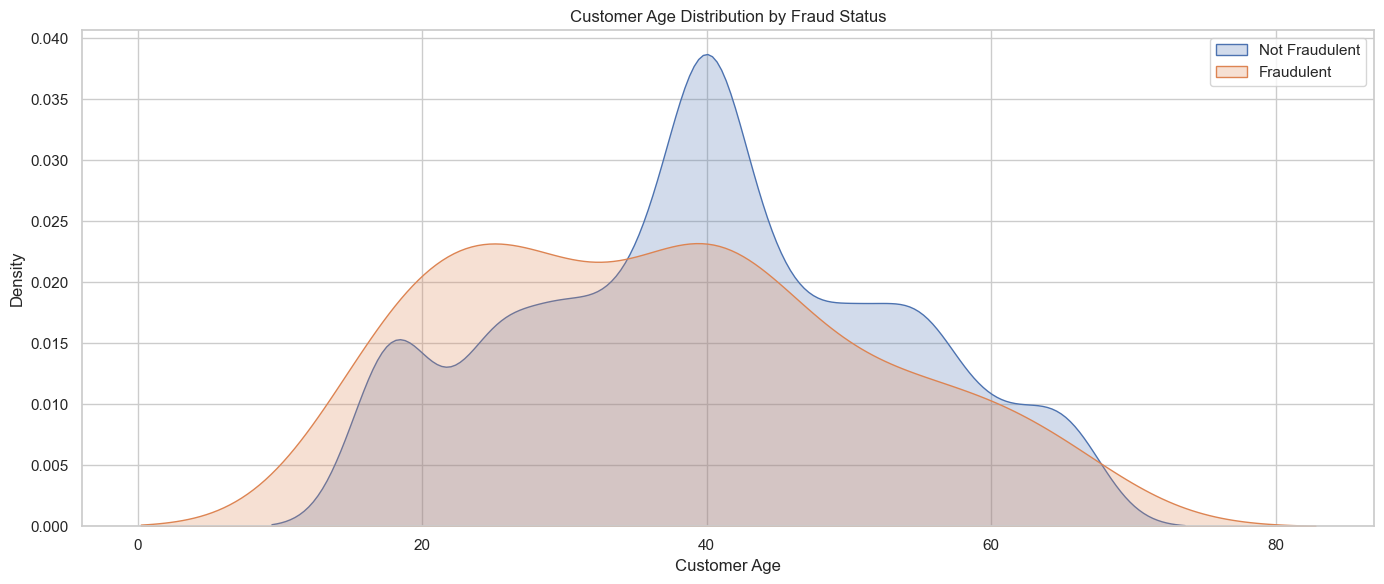

In [12]:
fraud_counts = df['IsFraudulent'].value_counts(normalize=True) * 100
plt.figure(figsize=(14, 6))
sns.kdeplot(df[df['IsFraudulent'] == 0]['CustomerAge'], label='Not Fraudulent', shade=True)
sns.kdeplot(df[df['IsFraudulent'] == 1]['CustomerAge'], label='Fraudulent', shade=True)
plt.title('Customer Age Distribution by Fraud Status')
plt.xlabel('Customer Age')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

#### Payment Type in Relation to Fraud

The bar plot indicates the distribution of transactions across different payment types and contrasts the count of fraudulent versus non-fraudulent transactions. This visualization can shed light on whether certain payment types are more prone to fraud than others.

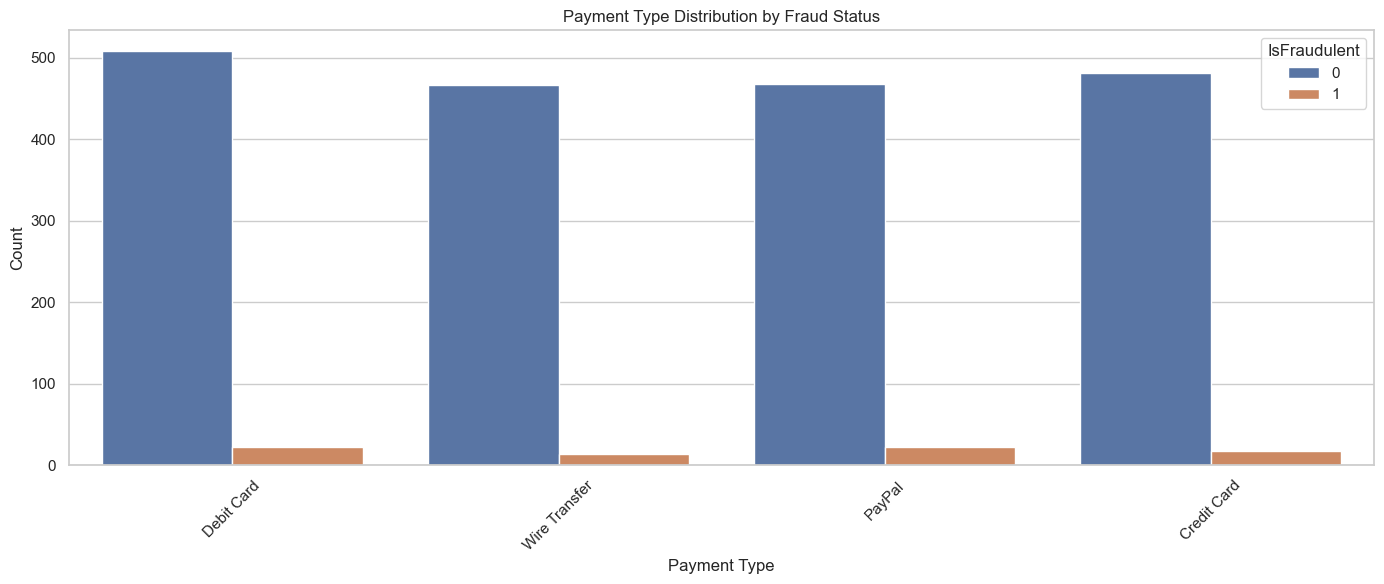

0    96.15
1     3.85
Name: IsFraudulent, dtype: float64

In [13]:

plt.figure(figsize=(14, 6))
sns.countplot(x='PaymentType', hue='IsFraudulent', data=df)
plt.title('Payment Type Distribution by Fraud Status')
plt.xlabel('Payment Type')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

fraud_counts

#### Merchant Analysis: Assessing the association of merchants with fraudulent transactions

Some merchants, specifically those with IDs 1463, 1636, and 1798, have a noticeably higher proportion of fraudulent transactions compared to others.
Several merchants have no recorded fraudulent transactions within the top transaction volumes, which could indicate either effective fraud prevention measures or a lower risk profile.

All transaction statuses experience some level of fraud, with Cancelled and Completed transactions having a slightly higher rate of fraud compared to Failed and Pending.

 These findings suggest potential areas for targeted fraud prevention efforts. For instance, merchants with a higher percentage of fraudulent transactions might need more rigorous verification processes. Similarly, certain transaction statuses that are more prone to fraud could warrant additional scrutiny.

In [14]:
# Grouping data by MerchantID and calculating the proportion of fraudulent transactions
merchant_fraud_dist = df.groupby('MerchantID')['IsFraudulent'].value_counts(normalize=True).unstack() * 100
top_merchants = df['MerchantID'].value_counts().head(10).index
top_merchant_fraud_dist = merchant_fraud_dist.loc[top_merchants].sort_values(by=1, ascending=False)


#### Transaction Status Analysis: Relationship between transaction status and fraud

<Figure size 1400x700 with 0 Axes>

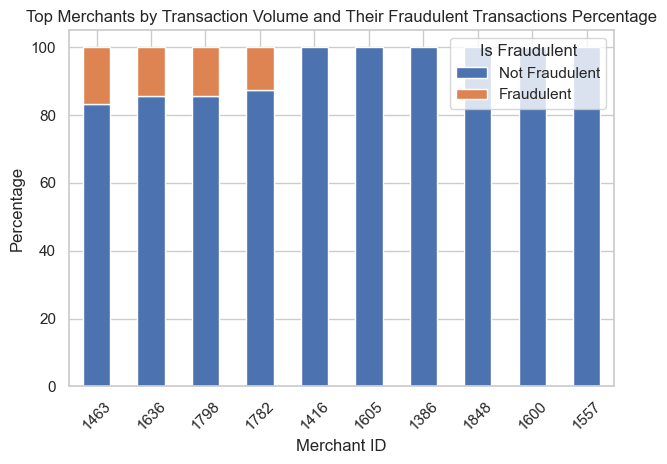

In [15]:
status_fraud_dist = df.groupby('TransactionStatus')['IsFraudulent'].value_counts(normalize=True).unstack() * 100
# Plotting the relationship between merchants and fraudulent transactions
plt.figure(figsize=(14, 7))
top_merchant_fraud_dist.plot(kind='bar', stacked=True)
plt.title('Top Merchants by Transaction Volume and Their Fraudulent Transactions Percentage')
plt.xlabel('Merchant ID')
plt.ylabel('Percentage')
plt.legend(title='Is Fraudulent', labels=['Not Fraudulent', 'Fraudulent'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1400x700 with 0 Axes>

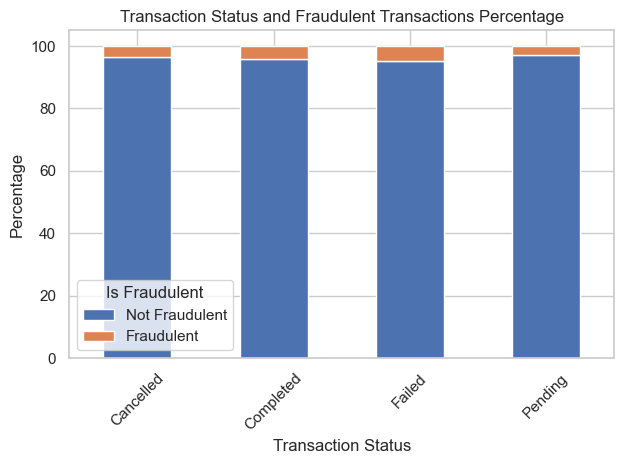

In [18]:
# Plotting the relationship between transaction status and fraud
plt.figure(figsize=(14, 7))
status_fraud_dist.plot(kind='bar', stacked=True)
plt.title('Transaction Status and Fraudulent Transactions Percentage')
plt.xlabel('Transaction Status')
plt.ylabel('Percentage')
plt.legend(title='Is Fraudulent', labels=['Not Fraudulent', 'Fraudulent'])
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [17]:
top_merchant_fraud_dist, status_fraud_dist

(IsFraudulent           0          1
 1463           83.333333  16.666667
 1636           85.714286  14.285714
 1798           85.714286  14.285714
 1782           87.500000  12.500000
 1416          100.000000        NaN
 1605          100.000000        NaN
 1386          100.000000        NaN
 1848          100.000000        NaN
 1600          100.000000        NaN
 1557          100.000000        NaN,
 IsFraudulent               0         1
 TransactionStatus                     
 Cancelled          96.421471  3.578529
 Completed          95.825771  4.174229
 Failed             95.248380  4.751620
 Pending            97.101449  2.898551)

#### Time Series Analysis: Daily and Hourly Trends in Fraudulent Transactions

By Day of the Week:

The number of fraudulent transactions seems to peak on Tuesdays and Fridays, with noticeable dips midweek on Wednesdays and towards the end of the week on Sundays. This could indicate patterns in customer behavior or fraudster activity on specific days.

By Hour of the Day:

There's a peak in fraudulent activity around midnight, with another smaller peak in the early evening around 6 PM. Overnight and early morning hours have the least fraudulent activity, which could be due to lower overall transaction volumes during these times.

These patterns suggest that fraud prevention efforts could be more heavily focused during the times identified as having higher fraudulent transaction activity. Moreover, the insights could be used to implement dynamic fraud detection systems that adapt based on time-based risk assessments.

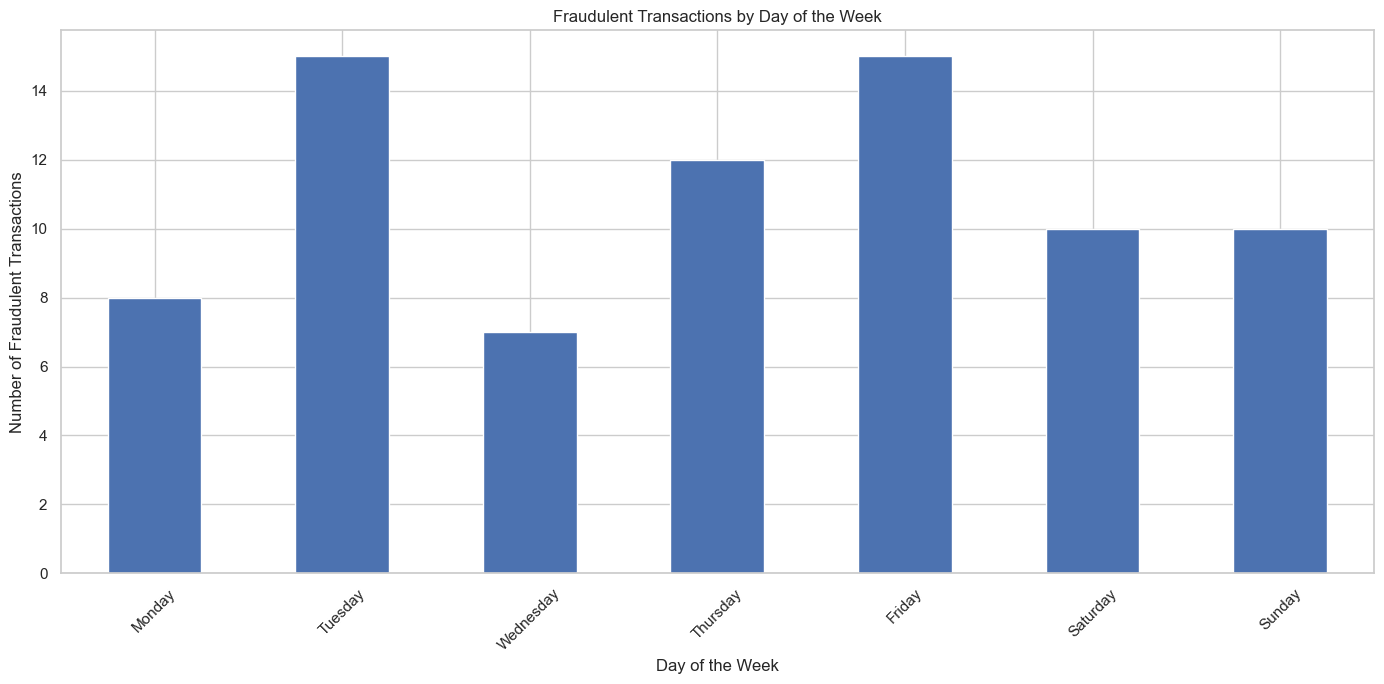

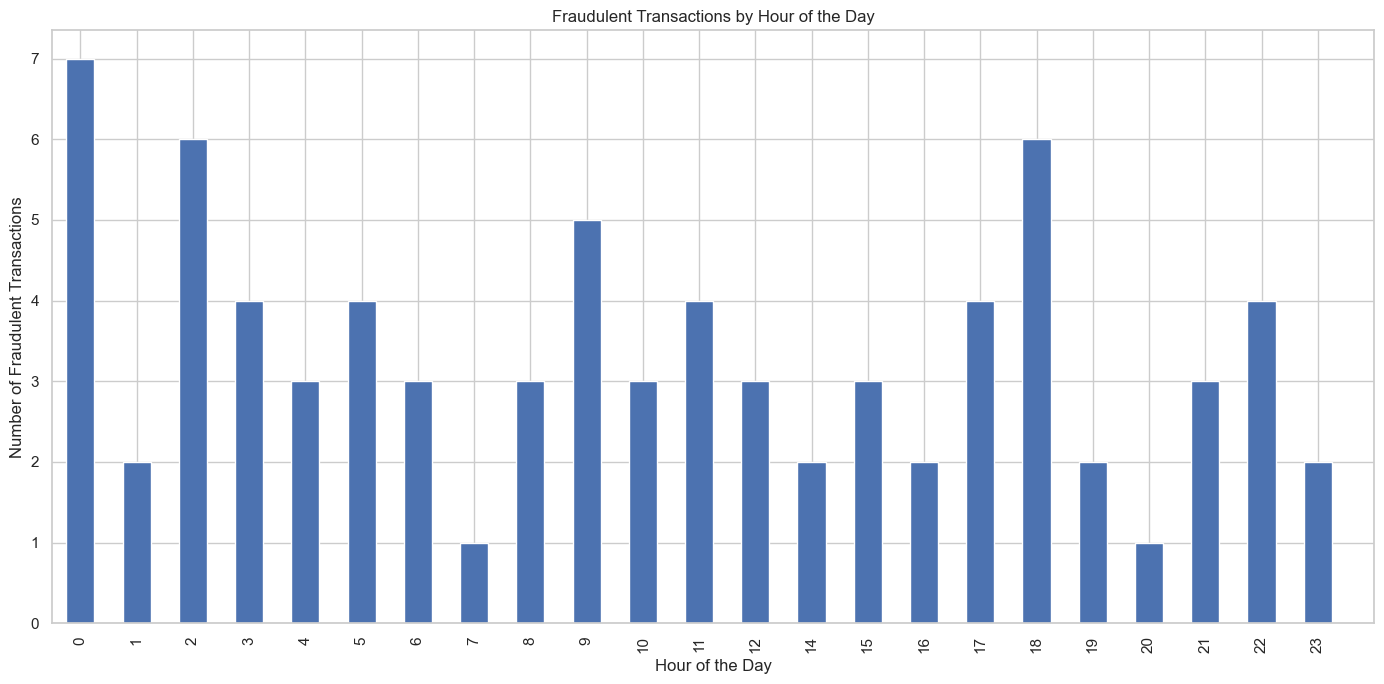

(DayOfWeek
 Monday        8
 Tuesday      15
 Wednesday     7
 Thursday     12
 Friday       15
 Saturday     10
 Sunday       10
 Name: TransactionID, dtype: int64,
 HourOfDay
 0     7
 1     2
 2     6
 3     4
 4     3
 5     4
 6     3
 7     1
 8     3
 9     5
 10    3
 11    4
 12    3
 14    2
 15    3
 16    2
 17    4
 18    6
 19    2
 20    1
 21    3
 22    4
 23    2
 Name: TransactionID, dtype: int64)

In [20]:
# Extracting day of week and hour of day from the TransactionDateTime
df['DayOfWeek'] = df['TransactionDateTime'].dt.day_name()
df['HourOfDay'] = df['TransactionDateTime'].dt.hour

# Grouping data by day of the week and hour of the day for fraudulent transactions
fraud_by_day = df[df['IsFraudulent'] == 1].groupby('DayOfWeek')['TransactionID'].count()
fraud_by_hour = df[df['IsFraudulent'] == 1].groupby('HourOfDay')['TransactionID'].count()

# Ordering the days of the week starting from Monday
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
fraud_by_day = fraud_by_day.reindex(ordered_days)

# Plotting Daily Trends in Fraudulent Transactions
plt.figure(figsize=(14, 7))
fraud_by_day.plot(kind='bar')
plt.title('Fraudulent Transactions by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Fraudulent Transactions')
plt.xticks(rotation=45)
plt.tight_layout()

# Plotting Hourly Trends in Fraudulent Transactions
plt.figure(figsize=(14, 7))
fraud_by_hour.plot(kind='bar')
plt.title('Fraudulent Transactions by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Fraudulent Transactions')
plt.xticks(np.arange(0, 24, 1))
plt.tight_layout()

plt.show()

fraud_by_day, fraud_by_hour


#### Correlation Analysis: Correlation between numerical features and fraud occurrences

There is a very small positive correlation (0.006) between the transaction Amount and IsFraudulent, suggesting a slightly higher tendency for higher amounts to be associated with fraud, but the relationship is not strong.

CustomerAge has a small negative correlation (-0.047) with IsFraudulent, indicating that younger customers may have a marginally higher incidence of fraud in their transactions.

Quantity shows an almost negligible correlation with IsFraudulent (0.002), suggesting that the quantity of items purchased isn't strongly related to fraudulent activity.

None of the numerical features exhibit a strong correlation with fraud occurrences. This suggests that fraud detection may require more complex patterns or combinations of features, not simply one or two numerical indicators. Advanced methods like machine learning algorithms might be necessary to detect these subtle patterns.

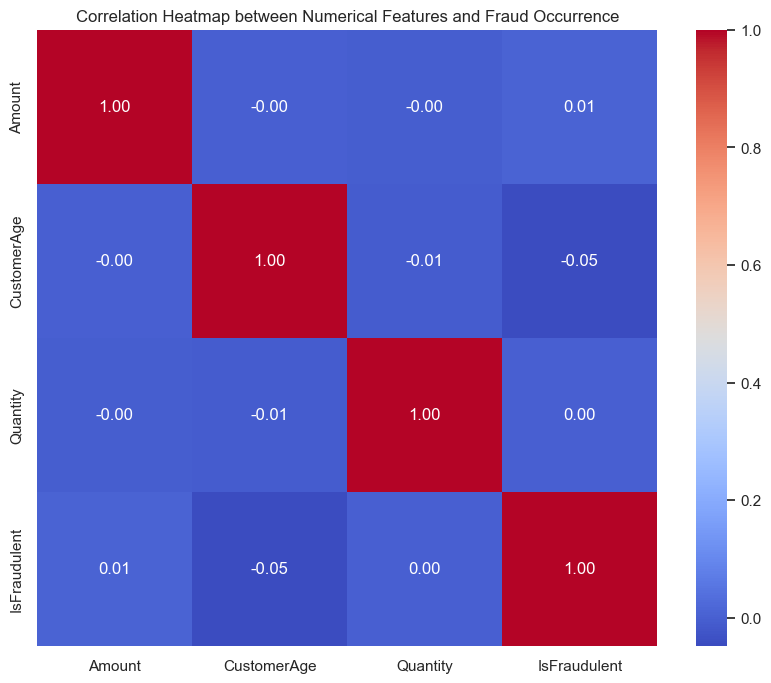

,Amount,CustomerAge,Quantity,IsFraudulent
Amount,1.000000,-0.000564,-0.003121,0.005816
CustomerAge,-0.000564,1.000000,-0.010134,-0.047372
Quantity,-0.003121,-0.010134,1.000000,0.001566
IsFraudulent,0.005816,-0.047372,0.001566,1.000000


In [21]:
numerical_features = df[['Amount', 'CustomerAge', 'Quantity', 'IsFraudulent']]
correlation_matrix = numerical_features.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap between Numerical Features and Fraud Occurrence')
plt.show()
correlation_matrix

#### Feature Engineering: Creating customer behavior features

In [22]:
# Average transaction amount per customer
df['AvgAmountPerCustomer'] = df.groupby('CustomerID')['Amount'].transform('mean')
# Frequency of transactions per customer
df['FrequencyPerCustomer'] = df.groupby('CustomerID')['TransactionID'].transform('count')
# Number of distinct products purchased by each customer
df['DistinctProductsPerCustomer'] = df.groupby('CustomerID')['ProductID'].transform('nunique')
df[['CustomerID', 'AvgAmountPerCustomer', 'FrequencyPerCustomer', 'DistinctProductsPerCustomer']].head()


,CustomerID,AvgAmountPerCustomer,FrequencyPerCustomer,DistinctProductsPerCustomer
0,103,800.355250,5,5
1,436,704.259062,4,4
2,349,870.016607,7,7
3,271,906.386562,4,4
4,107,844.153125,2,2


### Machine learning to predict fraudulent transactions

In [25]:
# Selecting features for the model and the target variable
X = df[['Amount', 'CustomerAge', 'Quantity', 'AvgAmountPerCustomer', 
        'FrequencyPerCustomer', 'DistinctProductsPerCustomer']]
y = df['IsFraudulent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Normalizing/Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled.shape, X_test_scaled.shape, y_train.shape, y_test.shape


((1400, 6), (600, 6), (1400,), (600,))

In [27]:
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_scaled, y_train)
y_pred = rf_clf.predict(X_test_scaled)

# Evaluating the Model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

accuracy


/Users/rafat/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rafat/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rafat/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.9616666666666667